# **HAVOK study** | forcing features

### **THRESHOLDING MODELS**

*Ref*: [github@baronefr/rhavok-analysis](github.com/baronefr/rhavok-analysis)


In [1]:
import rhavok
from rhavok.havok import havok
from rhavok.havok import externals

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler

from scipy import signal
from scipy.fft import fftshift

from tqdm.notebook import tqdm
import multiprocessing  # do you like multithreading?

In [2]:
# customizations used in this notebook
this_cm = plt.get_cmap('gist_rainbow')

In [3]:
dataset_files = "./data/havok/test_{}.npy"   # [t, v, x]
rocs_file = "./data/havok/rocs/{}.npz"

In [4]:
# behavioural
do_rocs = False   # compute the roc curves (time consuming)
do_save_rocs = False

In [5]:
rhavok.__version__

'0.1.4'

<br>

#### Data import

We import the test dataset from a previous HAVOK analysis run.

In [6]:
vv = np.load(dataset_files.format('v'))
tt = np.load(dataset_files.format('t'))
xx = np.load(dataset_files.format('x'))

In [7]:
print(vv.shape[1], 'signatures available')

21 signatures available


<br>

#### Visualize the embedded coordinates

For this analysis, it is helpful to visualize the embedded coordinates generated by Havok.

In [8]:
# plot spectrum of embedded coordinates
def plot_embedded_spectrum(x, t, v,             # data
                  limit, selection = None,      # what to plot
                  vf = lambda x: x,             # transformation function for v
                  figsize = (10,9), alpha = 1): # aesthetics
    
    limit = np.arange(limit[0], limit[1])
    
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[1,2]}, figsize=figsize, sharex=True)
    ax1.plot(t[limit], x[limit], c='k')
    ax1.set_ylabel('x(t)')
    
    if selection is None:
        selection = np.arange(2,v.shape[1]+1)
    elif isinstance(selection, int):
        selection = np.arange(2,selection+1)
    elif isinstance(selection, tuple):
        selection = np.arange(selection[0],selection[1]+1)
    elif isinstance(selection, list):
        pass
    selection = list(selection)
    
    ax2.set_prop_cycle( cycler( color=[this_cm(1.*i/len(selection)) for i in range(len(selection))] ))
    
    for ts in selection:
        ax2.plot(t[limit], vf(v[limit,ts-1]), label=str(ts), alpha=alpha)
    
    ax2.set_ylabel(r"$v_i(t)$")
    ax2.set_ylim([-.021,.021])
    ax2.legend()
    
    return fig

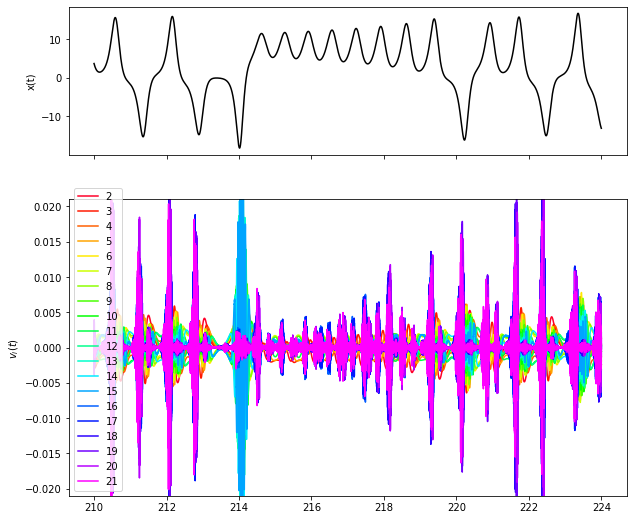

In [9]:
# the cool function above is already coded in rhavok!
externals.embedded_spectrum(xx, tt, vv, [10000,24000]).show()

<br><br>

## part 1 | **hard thresholding**

At first, we must set what does it mean that *'the forcing term is active'*. As seen in *Brunton et al., 2017*, we could set an optimal threshold level $\lambda_{thr}$ for the forcing term: whenever the amplitude exceeds $\lambda_{thr}$ in absolute value, we infer a prediction about the dynamic system behaviour. In our examples, it means that the Lorenz attractor is going to switch lobes. The threshold criteria is the following:

- if forcing\_term $v_i(t)$ is greater (abs) than the threshold $\lambda_{thr}$ $\;\Rightarrow\;$ mark the next 500 samples ($0.5s$) as triggered area.

In [10]:
#  Activity criteria: create a cluster when forcing
# signal is greater than a threashold
def active_by_thresh(forcing, thres = 0.002):
    
    above_thres = abs(forcing) > thres
    thres_expand = 500
    switch = False
    for i in range(0,len(above_thres)):
        if above_thres[i]:
            if not switch:
                above_thres[i:i+thres_expand] = True
                switch = True
        else:
            switch = False
    
    return above_thres

<br>
It is necessary to find an optimal threshold value $\lambda_{thr}$. We proceed by testing different threshold values and creating a ROC curve.

#### **ROC criteria**:
- true positive **TP**: the lobe switch is predicted in advance (must set a suitable criteria for 'advance')
- false negative **FN**: a sign switch occurs but there is no prediction issued in time
    - easily computed by $\text{FN} = n_{sign\_switch} - \text{TP}$
+ false positive **FP**: a trigger is issued but it is not followed by a sign switch
    - this can be easily computed by counting all the triggers occurring in the observed dataset $n_{tr}$ and subtracting the true positives:
    $$FP = n_{tr} - TP$$

The ROC curve is eventually built on
$$ TPR = \frac{TP}{TP+FN} = \frac{TP}{n_{sign\_switch}}$$

$$ FPR = \frac{FP}{FP+TN} = 1 - \frac{TP}{n_{tr}}$$

In [11]:
# evaluate the activity timeseries  (yet another walker)
def yawalker(acf, data, forcing, thres,
             confidence_max = 200, confidence_min = 0):
    #               (real sign switch)
    #   ---------------------X-------> time
    #     [========]         |  Havok activity window
    #               <------->|  confidence_min
    #     <----------------->|  confidence_max
    #
    
    # compute the activity (call the arg function)
    active_mask = acf(forcing, thres)
    
    # counters & loop variables
    nswitch = 0;    ntrigger = 0;    tp = 0;
    ntimeseries = len(data)
    prev_value = data[0];    prev_trigger = False;
    
    # let's walk though the timeseries
    for i in range(ntimeseries):
        if prev_value*data[i] <= 0:
            # there is a sign switch
            nswitch += 1
            if np.any(active_mask[(i-confidence_max):(i-confidence_min)]): tp += 1
            prev_value = data[i]
            
        if (active_mask[i] == True) and (prev_trigger == False): ntrigger += 1
        prev_trigger = active_mask[i]
    return tp, nswitch, ntrigger

def roc_stats(tp, nswitch, ntrigger, printer = False, print_precision = 4):
    # compute the ROC quantities
    tpr = tp/nswitch
    if ntrigger == 0: fpr = np.nan
    else: fpr = 1 - (tp/ntrigger)
    if printer: print("tpr = {}, fpr = {}".format( round(tpr,print_precision), round(fpr,print_precision)))
    return (tpr, fpr)

def wrapped_roc_stats( acf, data, vforce, thres ):
    # wrap together the two functions above
    return roc_stats( *yawalker(acf, data, vforce, thres = thres) )

<br>

##### example: call the ROC evaluator

In [12]:
# small demo on the 15th forcing term

tp, nsw, ntr = yawalker(active_by_thresh, xx, vv[:,14], thres = 0.002)
default_thres = roc_stats(tp, nsw, ntr, printer = True)  # this is the threshold used by Brunton et al.

tpr = 0.9802, fpr = 0.2534


In [13]:
# you can get the same result by calling wrapper_roc_stats()
%timeit -r 1 wrapped_roc_stats(active_by_thresh, xx, vv[:,14], thres = 0.002)

# you see: this takes quite a time!

2.13 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<br>

### create ROC for rank = 15

Let us evaluate the first ROC curve, using as forcing term the standard $v_{15}$.

In [14]:
def ROC(acf, forcing, thresholds):
    # Warning: this is the single threaded ROC function:
    # run it only if you are really desperate!
    tpr = np.empty(len(thresholds))
    fpr = np.empty(len(thresholds))
    for i, ths in enumerate(tqdm(thresholds)):
        tp, nsw, ntr = yawalker(acf, xx[-len(forcing):], forcing, thres = ths)
        tpr[i], fpr[i] = roc_stats(tp, nsw, ntr)
    return tpr, fpr
#########################################################

def multithreaded_ROC(executable, thresholds):
    p = multiprocessing.Pool()
    with p: rdata = p.map(executable, thresholds)
    
    # parse
    n = len(thresholds)
    tpr = np.empty(n);    fpr = np.empty(n);
    for i, c in enumerate(rdata):
        tpr[i], fpr[i] = c[0], c[1]
    return tpr, fpr
  
def plot_roc(tpr, fpr, figsize = (6,6), color = 'crimson', label = 'ROC threshold'):
    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, lw=2, c=color, label=label)
    plt.xlim([-.01,1.01])
    plt.ylim([0,1.01])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    return plt

In [15]:
# define a ROC executable
def ROC_v15(ithr):
    return wrapped_roc_stats(active_by_thresh, xx, vv[:,14], thres = ithr)
    #return roc_stats( *yawalker(active_by_thresh, xx, vv[:,14], thres = ithr) )

In [16]:
if do_rocs:
    thr_test = np.arange(0.0001, 0.0251, 0.0001)
    print("testing {} thresholds".format(len(thr_test)))
    
    # single-threaded... slow as hell!
    #tpr, fpr = ROC(active_by_thresh, vv[:,14], thr_test)  
    
    # multi-threaded
    tpr, fpr = multithreaded_ROC(ROC_v15, thr_test)

else:
    rdata = np.load(rocs_file.format('r15'))
    tpr=rdata['tpr'];  fpr=rdata['fpr'];  thr_test=rdata['thres'];
    print("tested {} thresholds".format(len(thr_test)))

tested 250 thresholds


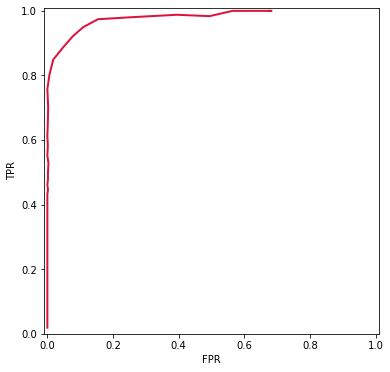

In [17]:
plot_roc(tpr, fpr).show()

In [18]:
if do_save_rocs:
    np.savez(rocs_file.format('r15'), tpr=tpr, fpr=fpr, thres=thr_test)
    print('saved')

<br>

### create ROC for more ranks

But why limiting the analysis only to $r = 15$? We have seen that it is possible to create a linearly forced model of the dynamic system choosing only one input. But actually, when it comes to predictions, it can be the chance that other eigen-timeseries are also able to give some information.

In [19]:
if do_rocs:
    thr_test = np.arange(0.0001, 0.0251, 0.0001)
    n = len(thr_test)
    print("testing {} thresholds".format(n))
    
    rank_test = [13, 14, 15, 16, 17, 18, 19, 20]
    nr = len(rank_test)
    print("testing {} ranks".format(nr))
    
    tpr = np.full((nr, n), np.nan) # index by rr value, then by curve points
    fpr = np.full((nr, n), np.nan)
    
    for i, rr in enumerate(tqdm(rank_test)):
        # define the executable
        def ROC_vi(ithr):
            return wrapped_roc_stats(active_by_thresh, xx, vv[:,rr], thres = ithr)
        
        # call the multithreaded ROC
        tpr[i], fpr[i] = multithreaded_ROC(ROC_vi, thr_test)
        
        
else:
    rdata = np.load(rocs_file.format('rall'))
    tpr=rdata['tpr'];  fpr=rdata['fpr'];   thr_test=rdata['thres'];
    rank_test=list(rdata['ranks'])
    n = len(thr_test);    nr = len(tpr);
    print("tested {} thresholds".format(n))

tested 250 thresholds


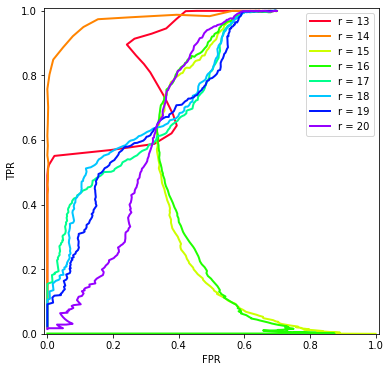

In [20]:
plt.figure(figsize=(6,6))

for i in range(nr):
    plt.plot(fpr[i], tpr[i], lw=2, c=this_cm(1.*i/nr), label=f'r = {rank_test[i]}')
    
plt.xlim([-.01,1.01])
plt.ylim([0,1.01])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

In [21]:
if do_save_rocs:
    np.savez(rocs_file.format('rall'), tpr=tpr, fpr=fpr,
             thres=thr_test, ranks=np.array(rank_test))
    print('saved')

<br><br>

## part 2 | **double hard thresholding**

In [22]:
selected_ranks = [vv[:,14], vv[:,19]]

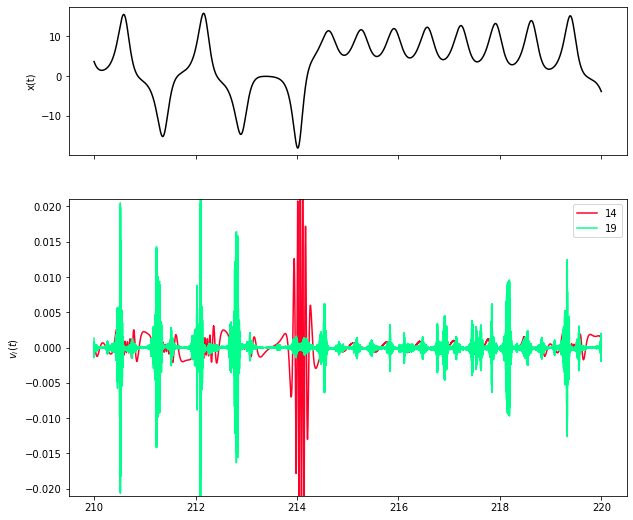

In [23]:
externals.embedded_spectrum(xx, tt, vv, [10000,20000], selection = [14,19]).show()

In [24]:
#  Activity criteria: create a cluster when forcing
# signals are greater than a threashold
def active_double_thresh(forcing, thres = [0.002, 0.002]):
    ath1 = abs(forcing[0]) > thres[0]
    ath2 = abs(forcing[1]) > thres[1]
    above_thres = np.array( [any(t) for t in zip(ath1, ath2)] , dtype = bool)
    thres_expand = 500
    switch = False
    for i in range(0,len(above_thres)):
        if above_thres[i]:
            if not switch:
                above_thres[i:i+thres_expand] = True
                switch = True
        else:
            switch = False
    
    return above_thres

In [25]:
def ROC_double(ithr):
    return wrapped_roc_stats(active_double_thresh, xx, selected_ranks, thres = ithr)

<br>

#### create ROC for 2-combination of ranks

In [26]:
if do_rocs:
    thr1 = np.arange(0.001, 0.0221, 0.001)
    nx = len(thr1)
    thr2 = np.arange(0.001, 0.0221, 0.001)
    ny = len(thr2)
    print('> gridsearch', nx,'x', ny)
    
    fpr_matrix = np.full( (nx,ny), np.nan)
    tpr_matrix = np.full( (nx,ny), np.nan)
    
    for i in tqdm(range(nx)):  # I want to do this just to have some intermediate update
        round_thres = np.array(np.meshgrid( [thr1[i]], thr2)).T.reshape(-1, 2)
        tpr_matrix[i], fpr_matrix[i] = multithreaded_ROC(ROC_double, round_thres )
    
else:
    rdata = np.load( rocs_file.format('rdouble') )
    tpr_matrix=rdata['tpr'];  fpr_matrix=rdata['fpr'];
    thr1=rdata['thres1'];     thr2=rdata['thres2'];
    nx = len(thr1);           ny = len(thr2);
    print('> tested gridsearch', nx,'x', ny)

> tested gridsearch 22 x 22


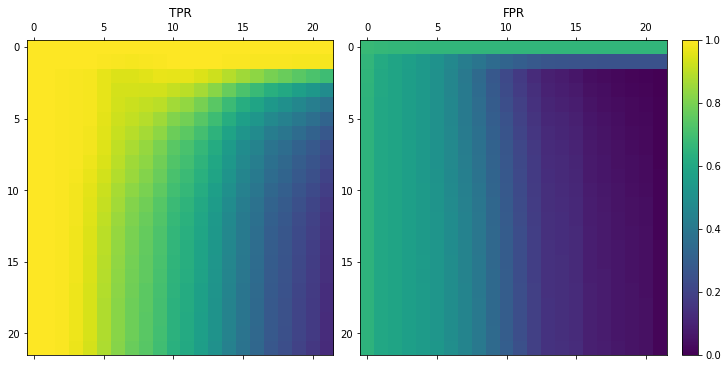

In [27]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,5))
ax[0].matshow(tpr_matrix, vmin=0, vmax=1, aspect='auto')
ax[0].set_title('TPR')

pc = ax[1].matshow(fpr_matrix, vmin=0, vmax=1, aspect='auto')
ax[1].set_title('FPR')

fig.colorbar(pc, ax=ax[1])
fig.show()

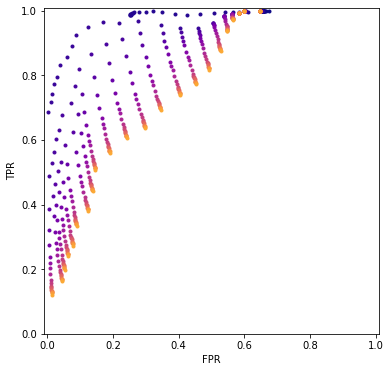

In [28]:
plt.figure(figsize=(6,6))
mappe = plt.get_cmap('plasma')

for i in range(nx):
    plt.scatter(fpr_matrix[i], tpr_matrix[i], color=mappe(1.*i/(nx+4)), marker='.')
        
plt.xlim([-.01,1.01])
plt.ylim([0,1.01])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [29]:
if do_save_rocs:
    np.savez(rocs_file.format('rdouble'), tpr=tpr_matrix, fpr=fpr_matrix,
             thres1=thr1, thres2=thr2 )
    print('saved')

<br>

### part 3 | create ROC for more ranks on smoothed v

In [30]:
def moving_average(a, n=3):
    ret = np.cumsum(a, axis = 0, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

vsmooth = moving_average(vv, n=20)
newsize = len(vsmooth)

(6000.0, 8000.0)

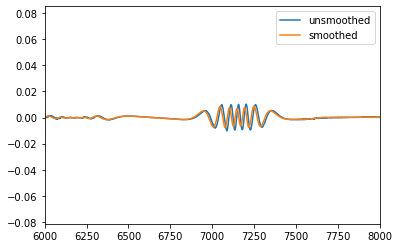

In [31]:
# compare the smoothing
plt.plot(vv[:,14], label = 'unsmoothed')
plt.plot(vsmooth[:,14], label = 'smoothed')
plt.legend()
plt.xlim([6000, 8000])

In [32]:
if do_rocs:
    thr_test_s = np.arange(0.0001, 0.0251, 0.0001)
    n = len(thr_test)
    print("testing {} thresholds".format(n))
    
    rank_test_s = [13, 14, 15, 16, 17, 18, 19, 20]
    nr = len(rank_test)
    print("testing {} ranks".format(nr))
    
    tprs = np.full((nr, n), np.nan) # index by rr value, then by curve points
    fprs = np.full((nr, n), np.nan)
    
    for i, rr in enumerate(tqdm(rank_test_s)):
        # define the executable
        def ROC_vi_smooth(ithr):
            return wrapped_roc_stats(active_by_thresh, xx[-newsize:], vsmooth[:,rr], thres = ithr)
        
        # call the multithreaded ROC
        tprs[i], fprs[i] = multithreaded_ROC(ROC_vi_smooth, thr_test_s)
        
        
else:
    rdata = np.load(rocs_file.format('rall_smooth'))
    tprs=rdata['tpr'];  fprs=rdata['fpr'];   thr_test_s=rdata['thres'];
    rank_test_s=list(rdata['ranks'])
    n = len(thr_test);    nr = len(tprs);
    print("tested {} thresholds".format(n))

tested 250 thresholds


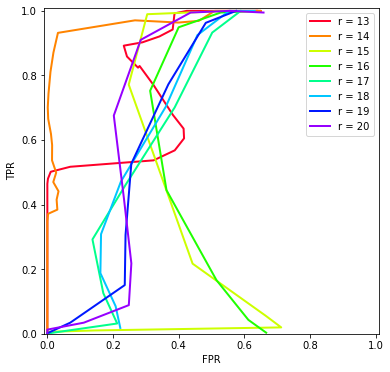

In [33]:
plt.figure(figsize=(6,6))

for i in range(nr):
    plt.plot(fprs[i], tprs[i], lw=2, c=this_cm(1.*i/nr), label=f'r = {rank_test_s[i]}')
    
plt.xlim([-.01,1.01])
plt.ylim([0,1.01])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

In [34]:
if do_save_rocs:
    np.savez(rocs_file.format('rall_smooth'), tpr=tprs, fpr=fprs,
             thres=thr_test_s, ranks=np.array(rank_test_s))
    print('saved')

In [35]:
dsdsdadas # stop here

NameError: name 'dsdsdadas' is not defined

<br><br><br>

## other stuff

In [ ]:
plt.plot(smoothed)
plt.xlim([6000,8000])

In [ ]:
selsig = smoothed
n = len(selsig)
q = 100
mw = np.copy( selsig[:q] )

zcr = np.empty(n-q)
for i in range(n-q):
    zero_crosses = np.nonzero(np.diff(mw > 0))[0]
    zcr[i] = zero_crosses.size
    mw = np.roll(mw, -1)
    mw[-1] = selsig[q+i]

In [ ]:
plt.plot(zcr)
plt.xlim([6000,10000])

In [ ]:
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()
ax_left.plot(np.arange(n)*dt, selsig, color='black')
ax_right.plot((np.arange(len(zcr))+q)*dt, zcr, color='red')
ax_left.set_xlim([0,40])
ax_left.set_ylim([-.03,.03])

In [ ]:
conv = abs(selsig[:len(zcr)])*zcr
plt.plot((np.arange(n)*dt)[:len(zcr)], conv)
plt.xlim([0,40])

In [ ]:
plt.plot(np.arange(len(data))*dt, data)
plt.xlim([0,40])

***

Code by *Francesco Barone*, last review: 31 May 2022. <br>**Workgroup**: Barone Francesco, Nagaro Gianmarco, Ninni Daniele, Valentini Lorenzo.

University of Padua, **Laboratory of Computational Physics**, module B.